# Выпускной проект: промышленность.  

## Погружение в доменную область

**Описание проекта**  

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

**Описание этапов обработки**  

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.  
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).  
Перед тем как *первый раз* ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.  
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).


**Описание данных**  

Данные состоят из файлов, полученных из разных источников:
 * data_arc_new.csv — данные об электродах;
 * data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
 * data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
 * data_gas_new.csv — данные о продувке сплава газом;
 * data_temp_new.csv — результаты измерения температуры;
 * data_wire_new.csv — данные о проволочных материалах (объём);
 * data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

Данные также находятся в тренажёре, в папке /datasets/.

**Цель проекта**  
Предсказание оптимальной температуры плавки. Она должна быть последней в цикле измерений.  
Целевая метрика - MAE < 6.8

**План проведения исследования**  
1) Погружение в доменную область:  
  - описание проекта;
  - описание технологического процесса;  
  - описание имеющихся данных;  
  - формирование цели исследование;
  - составление поэтапного плана исследования.

2) Анализ исходных данных и их предобработка:
  - импорт необходимых библиотек;  
  - выгрузка предоставленных данных;
  - описание и анализ исходных данных;
  - проверка типов данных;
  - обработка пропусков и др. 
  
3) Подготовка данных:  
  - проверка пространства признаков на мультиколлинеарность;  
  - формирование целостного датафрейма;
  - разделение датафрейма на пространство признаков и целевой признак;
  - формирование выборок.
  
4) Обучение моделей, сравнение результатов:  
  - выбор нескольких релевантных моделей;
  - обучение моделей с подбором гиперпарметров;
  - сопоставление результатов целевой метрики у моделей с лучшими гиперпараметрами.  
  
5) Проверка целевой метрики на выбранной модели с тестовой выборкой:
  - анализ полученного результата;
  - проверка модели на адекватность.
  
6) Отчёт о проделанном исследовании с финальным выводом.

## Анализ исходных данных и их предобработка

### Импорт библиотек

In [1]:
!pip install optuna

     |████████████████████████████████| 404 kB 2.2 MB/s eta 0:00:01


In [2]:
# import
import pandas as pd
import os
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

from optuna.samplers import RandomSampler
from optuna.samplers import GridSampler

RANDOM_STATE = 140823

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

### Подгружаем данные и выводим первичную информацию

In [3]:
# подгружаем данные
pth0_1 = '/datasets/data_arc_new.csv'
pth0_2 = 'C:/Users/bezpa/Downloads/data_arc_new.csv'

if os.path.exists(pth0_1):
    data_arc = pd.read_csv(pth0_1, parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
    print('data import from jupyterhub')
elif os.path.exists(pth0_2):
    data_arc = pd.read_csv(pth0_2, parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
    print('data import from local storage')
else:
    print('Check the PATH to data file please')

print()
print('Данные об электродах')
print('-----------------------------------------------------------')
data_arc.info()
print(data_arc.describe())
data_arc.head(5)

data import from jupyterhub

Данные об электродах
-----------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485
min        1.000000           0.223120          -715.479924
25%  

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [4]:
pth0_1 = '/datasets/data_bulk_new.csv'
pth0_2 = 'C:/Users/bezpa/Downloads/data_bulk_new.csv'

if os.path.exists(pth0_1):
    data_bulk = pd.read_csv(pth0_1)
    print('data import from jupyterhub')
elif os.path.exists(pth0_2):
    data_bulk = pd.read_csv(pth0_2)
    print('data import from local storage')
else:
    print('Check the PATH to data file please')

print()
print('Данные о подаче сыпучих материалов (объём)')
print('-----------------------------------------------------------')
data_bulk.info()
print(data_arc.describe())
data_bulk.head(5)

data import from jupyterhub

Данные о подаче сыпучих материалов (объём)
-----------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
                key  Акт

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [5]:
pth0_1 = '/datasets/data_bulk_time_new.csv'
pth0_2 = 'C:/Users/bezpa/Downloads/data_bulk_time_new.csv'

if os.path.exists(pth0_1):
    data_bulk_time = pd.read_csv(pth0_1, parse_dates=['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', \
                                                 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', \
                                                 'Bulk 13', 'Bulk 14', 'Bulk 15'])
    print('data import from jupyterhub')
elif os.path.exists(pth0_2):
    data_bulk_time = pd.read_csv(pth0_2, parse_dates=['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', \
                                                 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', \
                                                 'Bulk 13', 'Bulk 14', 'Bulk 15'])
    print('data import from local storage')
else:
    print('Check the PATH to data file please')
    
print()
print('Данные о подаче сыпучих материалов (время)')
print('-----------------------------------------------------------')
data_bulk_time.info()
print(data_arc.describe())
data_bulk_time.head(5)

data import from jupyterhub

Данные о подаче сыпучих материалов (время)
-----------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


In [6]:
pth0_1 = '/datasets/data_gas_new.csv'
pth0_2 = 'C:/Users/bezpa/Downloads/data_gas_new.csv'

if os.path.exists(pth0_1):
    data_gas = pd.read_csv(pth0_1)
    print('data import from jupyterhub')
elif os.path.exists(pth0_2):
    data_gas = pd.read_csv(pth0_2)
    print('data import from local storage')
else:
    print('Check the PATH to data file please')

print()
print('Данные о продувке сплава газом')
print('-----------------------------------------------------------')
data_gas.info()
print(data_arc.describe())
data_gas.head(5)

data import from jupyterhub

Данные о продувке сплава газом
-----------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485
min        1.000000           0.223120          -715.479924
25%      806.000000           0.467115             0.337175
50%     1617.000000           0.599587             0.441639
75%     2429.000000           0.830070             0.608201
max     3241.000000           1.463773             1.270284


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [7]:
pth0_1 = '/datasets/data_temp_new.csv'
pth0_2 = 'C:/Users/bezpa/Downloads/data_temp_new.csv'

if os.path.exists(pth0_1):
    data_temp = pd.read_csv(pth0_1, parse_dates=['Время замера'])
    print('data import from jupyterhub')
elif os.path.exists(pth0_2):
    data_temp = pd.read_csv(pth0_2, parse_dates=['Время замера'])
    print('data import from local storage')
else:
    print('Check the PATH to data file please')

print()
print('Результаты измерения температуры')
print('-----------------------------------------------------------')
data_temp.info()
print(data_arc.describe())
data_temp.head(5)

data import from jupyterhub

Результаты измерения температуры
-----------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB
                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485
min        1.000000           0.223120          -715.479924
25%      806.000000           0.467115             0.337175
50%     1617.000000           0.599587             0.441639
75%     2429.000000          

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [8]:
pth0_1 = '/datasets/data_wire_new.csv'
pth0_2 = 'C:/Users/bezpa/Downloads/data_wire_new.csv'

if os.path.exists(pth0_1):
    data_wire = pd.read_csv(pth0_1)
    print('data import from jupyterhub')
elif os.path.exists(pth0_2):
    data_wire = pd.read_csv(pth0_2)
    print('data import from local storage')
else:
    print('Check the PATH to data file please')
    
print()
print('Данные о проволочных материалах (объём)')
print('-----------------------------------------------------------')
data_wire.info()
print(data_arc.describe())
data_wire.head(5)

data import from jupyterhub

Данные о проволочных материалах (объём)
-----------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.438986
std      934.571502           0.258885             5.873485
min        1.000000         

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
pth0_1 = '/datasets/data_wire_time_new.csv'
pth0_2 = 'C:/Users/bezpa/Downloads/data_wire_time_new.csv'

if os.path.exists(pth0_1):
    data_wire_time = pd.read_csv(pth0_1, parse_dates=['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', \
                                                      'Wire 7', 'Wire 8', 'Wire 9'])
    print('data import from jupyterhub')
elif os.path.exists(pth0_2):
    data_wire_time = pd.read_csv(pth0_2, parse_dates=['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', \
                                                      'Wire 7', 'Wire 8', 'Wire 9'])
    print('data import from local storage')
else:
    print('Check the PATH to data file please')
    
print()
print('Данные о проволочных материалах (время)')
print('-----------------------------------------------------------')
data_wire_time.info()
print(data_arc.describe())
data_wire_time.head(5)

data import from jupyterhub

Данные о проволочных материалах (время)
-----------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB
                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.662752             0.4389

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


#### Описание результата  
1) В датасете с данными об электродах повторяются значения `key`. Вероятно, подразумевается несколько циклов обработки сплава. Нужно будет сгруппировать и посчитать количественно для каждого `key` упоминания;  
2) Временные данные не распарсились автоматически при инициаализации. Их можно преобразовать с помощью команды или добавить параметр `parse_dates` в команду `read_csv`. Лучше добавить в инициализацию;  
3) Стиль оформления заголовков таблиц нужно привести к единообразию, с учётом устоявшихся норм в сообществе;  
4) Нужно проверить все датасеты на явные дубликаты и посчитать кол-во пропусков. Заказчика интересуют только полные данные;  
5) Исходя из дополнительной информации о технологическом процессе, нам известно, что предсказать требуется последний замер из `data_temp` для `key`, также становится известно, что на нагрев сплава, то есть полезную работу, затрачивается активная мощность, но заказчик собирается экономить за счёт полной мощности. Нужно проверить характер распределения температуры, активной и реактивной мощности, определить взаимосвязь мощностей.

### Предобработка данных

In [10]:
# сразу разберёмся со стилем имён столбцов
data_arc.columns = ['key', 'start_warm_time', 'end_warm_time', 'active_power', 'reactive_power']
data_bulk.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', \
                     'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
data_bulk_time.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', \
                          'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']
data_gas.columns = ['key', 'gas_1']
data_temp.columns = ['key', 'time', 'temp']
data_wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', \
                     'wire_9']
data_wire_time.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', \
                          'wire_9']

# добвим все датасеты в один список для будущей автоматизации
data_var_names = ['data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire_time']
data_var_list = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]

In [11]:
for indx in range(len(data_var_list)):
    print(data_var_names[indx])
    print(data_var_list[indx]['key'].value_counts())
    print('--------------------------------------------------------------------')

data_arc
2108    16
1689    15
1513    15
2567    14
46      13
        ..
977      1
247      1
2582     1
248      1
530      1
Name: key, Length: 3214, dtype: int64
--------------------------------------------------------------------
data_bulk
2049    1
2612    1
2588    1
541     1
2590    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3129, dtype: int64
--------------------------------------------------------------------
data_bulk_time
2049    1
2612    1
2588    1
541     1
2590    1
       ..
1090    1
3139    1
1092    1
3141    1
2047    1
Name: key, Length: 3129, dtype: int64
--------------------------------------------------------------------
data_gas
2049    1
3135    1
3115    1
1070    1
3119    1
       ..
2596    1
549     1
2600    1
553     1
2047    1
Name: key, Length: 3239, dtype: int64
--------------------------------------------------------------------
data_temp
2108    17
1513    16
1689    16
2567    15
322     14
        ..
55

Видим, что для `data_arc` & `data_temp` значения `key` употребляются по несколько раз. В остальных датасетах они уникальные.

In [12]:
# функция подсчёта дубликатов и пропусков
def check_data_quality(data):
    print('Количество дубликатов:')
    display(data.duplicated().sum())
    print('--------------------------------------------------------------------')
    print('Количество пропусков:')
    display(data.isna().sum())
    print('--------------------------------------------------------------------')
    print('Среднее количество пропусков на столбец:')
    display(data.isna().mean())
    print('--------------------------------------------------------------------')

In [13]:
for indx in range(len(data_var_list)):
    print(data_var_names[indx])
    check_data_quality(data_var_list[indx])
    print('------------------------------NEXT DF--------------------------------------')

data_arc
Количество дубликатов:


0

--------------------------------------------------------------------
Количество пропусков:


key                0
start_warm_time    0
end_warm_time      0
active_power       0
reactive_power     0
dtype: int64

--------------------------------------------------------------------
Среднее количество пропусков на столбец:


key                0.0
start_warm_time    0.0
end_warm_time      0.0
active_power       0.0
reactive_power     0.0
dtype: float64

--------------------------------------------------------------------
------------------------------NEXT DF--------------------------------------
data_bulk
Количество дубликатов:


0

--------------------------------------------------------------------
Количество пропусков:


key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64

--------------------------------------------------------------------
Среднее количество пропусков на столбец:


key        0.000000
bulk_1     0.919463
bulk_2     0.992969
bulk_3     0.585171
bulk_4     0.675935
bulk_5     0.975391
bulk_6     0.815916
bulk_7     0.992010
bulk_8     0.999680
bulk_9     0.993928
bulk_10    0.943752
bulk_11    0.943432
bulk_12    0.217002
bulk_13    0.994247
bulk_14    0.103228
bulk_15    0.281560
dtype: float64

--------------------------------------------------------------------
------------------------------NEXT DF--------------------------------------
data_bulk_time
Количество дубликатов:


0

--------------------------------------------------------------------
Количество пропусков:


key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64

--------------------------------------------------------------------
Среднее количество пропусков на столбец:


key        0.000000
bulk_1     0.919463
bulk_2     0.992969
bulk_3     0.585171
bulk_4     0.675935
bulk_5     0.975391
bulk_6     0.815916
bulk_7     0.992010
bulk_8     0.999680
bulk_9     0.993928
bulk_10    0.943752
bulk_11    0.943432
bulk_12    0.217002
bulk_13    0.994247
bulk_14    0.103228
bulk_15    0.281560
dtype: float64

--------------------------------------------------------------------
------------------------------NEXT DF--------------------------------------
data_gas
Количество дубликатов:


0

--------------------------------------------------------------------
Количество пропусков:


key      0
gas_1    0
dtype: int64

--------------------------------------------------------------------
Среднее количество пропусков на столбец:


key      0.0
gas_1    0.0
dtype: float64

--------------------------------------------------------------------
------------------------------NEXT DF--------------------------------------
data_temp
Количество дубликатов:


0

--------------------------------------------------------------------
Количество пропусков:


key        0
time       0
temp    3427
dtype: int64

--------------------------------------------------------------------
Среднее количество пропусков на столбец:


key     0.000000
time    0.000000
temp    0.189421
dtype: float64

--------------------------------------------------------------------
------------------------------NEXT DF--------------------------------------
data_wire
Количество дубликатов:


0

--------------------------------------------------------------------
Количество пропусков:


key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64

--------------------------------------------------------------------
Среднее количество пропусков на столбец:


key       0.000000
wire_1    0.008439
wire_2    0.649789
wire_3    0.979552
wire_4    0.995456
wire_5    0.999675
wire_6    0.976306
wire_7    0.996430
wire_8    0.993833
wire_9    0.990587
dtype: float64

--------------------------------------------------------------------
------------------------------NEXT DF--------------------------------------
data_wire_time
Количество дубликатов:


0

--------------------------------------------------------------------
Количество пропусков:


key          0
wire_1      26
wire_2    2002
wire_3    3018
wire_4    3067
wire_5    3080
wire_6    3008
wire_7    3070
wire_8    3062
wire_9    3052
dtype: int64

--------------------------------------------------------------------
Среднее количество пропусков на столбец:


key       0.000000
wire_1    0.008439
wire_2    0.649789
wire_3    0.979552
wire_4    0.995456
wire_5    0.999675
wire_6    0.976306
wire_7    0.996430
wire_8    0.993833
wire_9    0.990587
dtype: float64

--------------------------------------------------------------------
------------------------------NEXT DF--------------------------------------


**Оценим распределение величин**

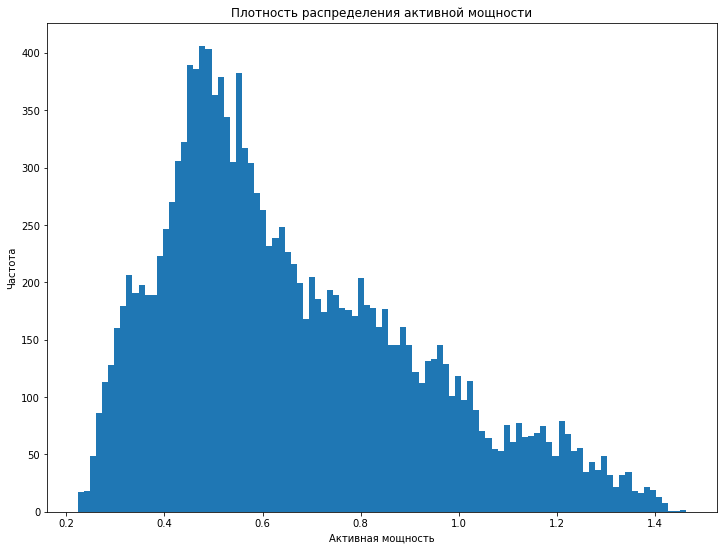

In [14]:
plt.figure(figsize=(12, 9))
plt.hist(data_arc['active_power'], bins=100)
plt.title('Плотность распределения активной мощности')
plt.xlabel('Активная мощность')
plt.ylabel('Частота')
plt.show()

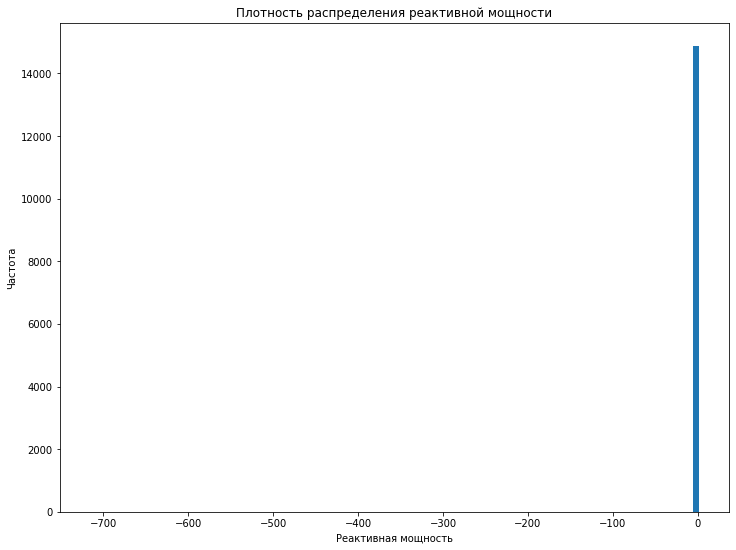

In [15]:
plt.figure(figsize=(12, 9))
plt.hist(data_arc['reactive_power'], bins=100)
plt.title('Плотность распределения реактивной мощности')
plt.xlabel('Реактивная мощность')
plt.ylabel('Частота')
plt.show()

Сразу видим выбросы меньше 0, избавляемся от них и перепроверяем распределение.

In [16]:
data_arc = data_arc[data_arc['reactive_power'] >= 0]

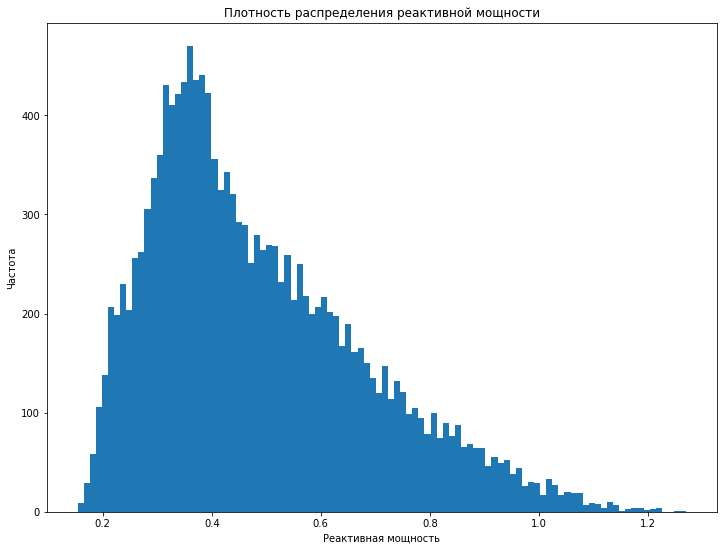

In [17]:
plt.figure(figsize=(12, 9))
plt.hist(data_arc['reactive_power'], bins=100)
plt.title('Плотность распределения реактивной мощности')
plt.xlabel('Реактивная мощность')
plt.ylabel('Частота')
plt.show()

И активная и реактивня мощности обладают нормлаьным распределением, пропусков нет.

Согласно информации из открытых источников (https://www.powersol.com.ua/poleznaya-informacziya/chto-takoe-moschnost/), полная мощность связывает между собой активную и реактивную мощность, словно гипотенуза прямоугольного трекгольника, вычисляется она по аналогичной формуле.
Таким образом, наилучшим решением будет заменить 2 признака одним общим.

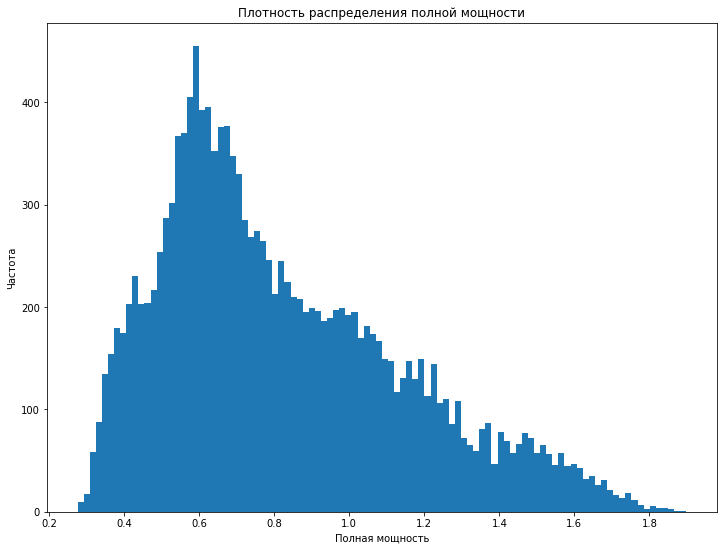

In [18]:
data_arc['full_power'] = (data_arc['active_power']**2 + data_arc['reactive_power']**2) ** (1/2)
plt.figure(figsize=(12, 9))
plt.hist(data_arc['full_power'], bins=100)
plt.title('Плотность распределения полной мощности')
plt.xlabel('Полная мощность')
plt.ylabel('Частота')
plt.show()

In [19]:
# удаляем объединённые признаки
data_arc = data_arc.drop(['active_power','reactive_power'], axis=1)
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   key              14875 non-null  int64         
 1   start_warm_time  14875 non-null  datetime64[ns]
 2   end_warm_time    14875 non-null  datetime64[ns]
 3   full_power       14875 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 581.1 KB


Время начала и конца нагрева обладает малой информативностью для модели, а вот продолжительность нагрева, выраженная в виде разницы между концом и началом, является полезным признаком.

In [20]:
data_arc['warm_time'] = (data_arc['end_warm_time'] - data_arc['start_warm_time']).dt.seconds
data_arc = data_arc.drop(['start_warm_time','end_warm_time'], axis=1)
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14875 entries, 0 to 14875
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         14875 non-null  int64  
 1   full_power  14875 non-null  float64
 2   warm_time   14875 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 464.8 KB


В датасете имеется несколько групп данных, связанных одним ключом `key`.  
Нам не требуется обладать информацией о показателях на каждом этапе, поэтому их можно объединить (сгруппировать) относительно ключа.

In [21]:
data_arc = data_arc.groupby(by='key', as_index=False).sum()
data_arc.info()
display(data_arc)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         3214 non-null   int64  
 1   full_power  3214 non-null   float64
 2   warm_time   3214 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 100.4 KB


,key,full_power,warm_time
0,1,3.718736,1098
1,2,2.588349,811
2,3,5.019223,655
3,4,3.400038,741
4,5,2.816980,869
...,...,...,...
3209,3237,3.250657,909
3210,3238,1.723937,546
3211,3239,6.014480,1216
3212,3240,4.082920,839


Сразу проверим распределение температуры.

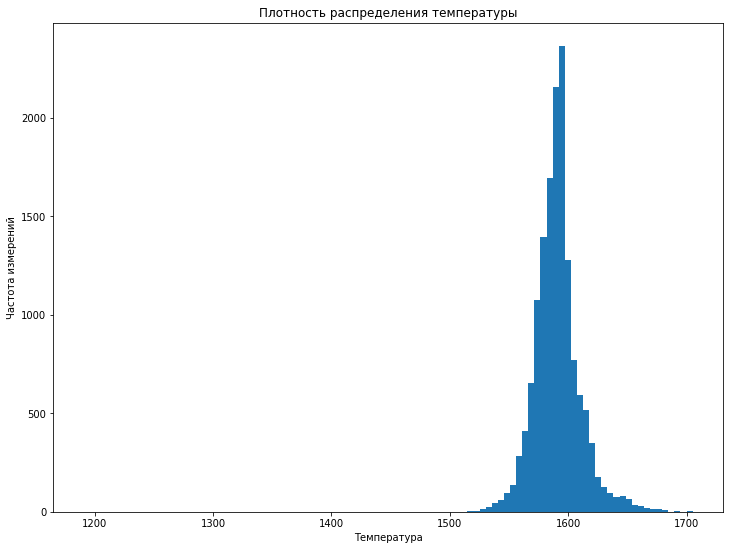

In [22]:
plt.figure(figsize=(12, 9))
plt.hist(data_temp['temp'], bins=100)
plt.title('Плотность распределения температуры')
plt.xlabel('Температура')
plt.ylabel('Частота измерений')
plt.show()

Температура обладает нормальным храктером распределения, присуствует 3427 пропуска, удаляем их.  
Также в наборе данных есть замеры ниже темпертуры плавления стали, которые нам не интересны, их можно удалить.

In [23]:
data_temp = data_temp.query('temp >= 1500')

In [24]:
data_temp.dropna().reset_index(drop = True)
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14660 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     14660 non-null  int64         
 1   time    14660 non-null  datetime64[ns]
 2   temp    14660 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 458.1 KB


На данном этапе также можно убрать все промежуточные измерения температуры, оставив только первое и последнее.
При сортировке можно указать, что кол-во элементов должно быть более 1, тогда мы отбросим партии, в которых всего одно измерение температуры.

In [25]:
data_temp_clean = pd.DataFrame()
for key in data_temp['key'].unique():
    time_temp_sort = data_temp[data_temp['key']==key].sort_values(by='time')
    if len(time_temp_sort) > 1:
        data_temp_clean = data_temp_clean.append(time_temp_sort.head(1))
        data_temp_clean = data_temp_clean.append(time_temp_sort.tail(1))

data_temp_clean.info()
data_temp_clean.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4950 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     4950 non-null   int64         
 1   time    4950 non-null   datetime64[ns]
 2   temp    4950 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 154.7 KB


,key,time,temp
0,1,2019-05-03 11:02:04,1571.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
10,2,2019-05-03 11:55:09,1602.0
11,3,2019-05-03 12:06:44,1596.0


Теперь транспанируем таблицу, а фактическое время заменяем разницей между первым и последним измерением.

In [26]:
col_values = []
for key in data_temp_clean['key'].unique():
    df = data_temp_clean[data_temp_clean['key']==key].reset_index(drop=True)
    frst_meas = df.loc[0,'temp']
    last_meas = df.loc[1,'temp']
    time_diff = (df.loc[1,'time'] - df.loc[0,'time']).seconds
    
    col_values.append([key, frst_meas, last_meas, time_diff])
    
data_temp_final = pd.DataFrame(col_values,
                               columns=['key', 'frst_meas', 'last_meas', 'time_diff'])

data_temp_final

,key,frst_meas,last_meas,time_diff
0,1,1571.0,1613.0,1714
1,2,1581.0,1602.0,1265
2,3,1596.0,1599.0,1753
3,4,1601.0,1625.0,1220
4,5,1576.0,1602.0,1536
...,...,...,...,...
2470,2495,1570.0,1591.0,1380
2471,2496,1554.0,1591.0,1705
2472,2497,1571.0,1589.0,962
2473,2498,1591.0,1594.0,1520


Проверяем распределение данных по подаче газа.

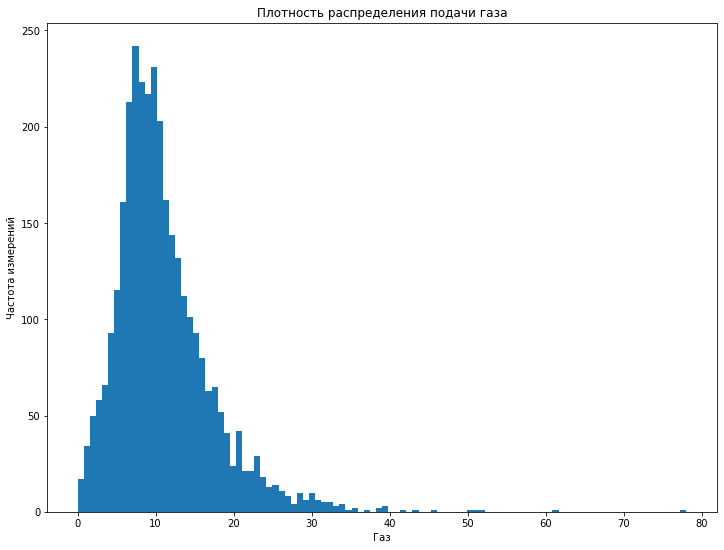

In [27]:
plt.figure(figsize=(12, 9))
plt.hist(data_gas['gas_1'], bins=100)
plt.title('Плотность распределения подачи газа')
plt.xlabel('Газ')
plt.ylabel('Частота измерений')
plt.show()

Данные имеют нормальное распределение, пропусков нет.

Далее проверим распределение данных по подаче сыпучих и проволочных материалов (объём).

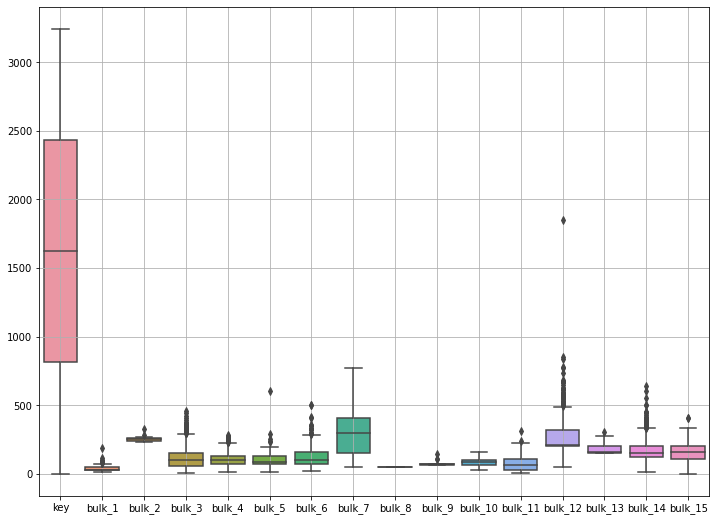

In [28]:
plt.figure(figsize=(12,9))
sns.boxplot(data=data_bulk)
plt.grid();

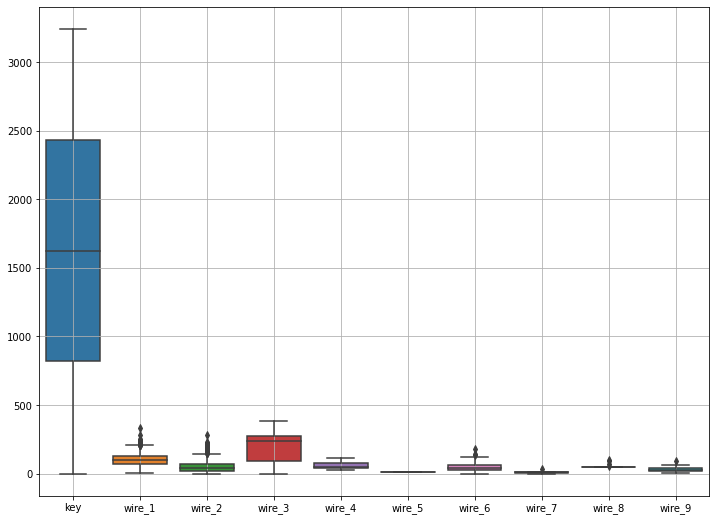

In [29]:
plt.figure(figsize=(12,9))
sns.boxplot(data=data_wire)
plt.grid();

Тип данных нормальный, имеется значительное количество пропусков в обоих датасетах.

Вероятно, самым рациональным решением по заполнению пропусков будет заполнить их 0.

In [30]:
for indx in range(len(data_var_list)):
    data_var_list[indx] = data_var_list[indx].fillna(value=0, inplace=True)
    print(f'For DF {data_var_names[indx]} change completed')

For DF data_arc change completed
For DF data_bulk change completed
For DF data_bulk_time change completed
For DF data_gas change completed
For DF data_temp change completed
For DF data_wire change completed
For DF data_wire_time change completed


### Выводы  
1. На данном этапе были загружены необходимые библиотеки;
2. Данные, предоставленные клиентом, были иницилизированы, проверены на соответствие типов, полноту и адекватность;
3. Почистили данные от аномалий;
4. Заменили два взаимосвзянных признака одним;
5. В датафрейме с измерением температуры оставили только начальное и конечное значение;  
6. В датафреме с электродами сгруппировали признаки относительно номера партии;  
7. Заменили пропущенные значения нулями.

## Подготовка данных

### Формирование единого датасета

Из подготовленных выше датафреймов составим единый датасет, из которого потом будут сформированы выборки и наборы признаков.  
Объединяем функцией `merge` по столбцу `key`, способ объединения - `inner`, так в финальную таблицу войдут только те ключи, что есть во всех датафреймах.

In [31]:
data_full = data_temp_final.merge(right=data_arc,
                                        how='inner',
                                        on='key').merge(right=data_bulk,
                                                        how='inner',
                                                        on='key').merge(right=data_gas,
                                                                        how='inner',
                                                                        on='key').merge(right=data_wire,
                                                                                        how='inner',
                                                                                        on='key')

display(data_full)
data_full.describe()

,key,frst_meas,last_meas,time_diff,full_power,warm_time,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas_1,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,1571.0,1613.0,1714,3.718736,1098,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1581.0,1602.0,1265,2.588349,811,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1596.0,1599.0,1753,5.019223,655,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1601.0,1625.0,1220,3.400038,741,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1576.0,1602.0,1536,2.816980,869,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1570.0,1591.0,1380,3.868721,723,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2325,2496,1554.0,1591.0,1705,5.070316,940,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2326,2497,1571.0,1589.0,962,4.360918,569,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2327,2498,1591.0,1594.0,1520,3.909917,750,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,key,frst_meas,last_meas,time_diff,full_power,warm_time,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas_1,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.0,2329.000000,2329.000000,2329.000000,2329.000000
mean,1251.832546,1587.386003,1593.365393,2321.810219,3.884654,807.600687,3.427651,1.422499,47.348218,37.303564,2.640189,22.430228,2.004723,0.021039,0.444826,5.052812,4.245170,208.415629,1.067411,153.853585,119.952769,11.375600,102.443601,17.609859,3.234916,0.306550,0.0,0.978820,0.006361,0.311311,0.317113
std,714.762400,23.619841,11.200915,1385.191527,1.518157,340.897332,12.412132,19.082119,75.310430,58.643238,22.402293,55.790873,30.676234,1.015340,6.220641,20.917800,22.515487,157.062272,14.235055,81.404354,84.640443,6.392041,43.539993,33.624771,27.942871,4.757746,0.0,8.693299,0.205705,4.402707,3.456561
min,1.000000,1519.000000,1541.000000,270.000000,0.331897,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,630.000000,1571.000000,1587.000000,1579.000000,2.843058,581.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,7.282948,73.207679,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1255.000000,1587.000000,1593.000000,2045.000000,3.767499,778.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,10.100950,101.119201,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,1868.000000,1603.000000,1598.000000,2791.000000,4.769421,993.000000,0.000000,0.000000,80.000000,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.000000,0.000000,204.000000,204.000000,14.216688,128.091599,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,2499.000000,1660.000000,1653.000000,23674.000000,15.288271,4189.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,77.995040,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600


Колонка `wire_5` заполнена только 0, её можно удалить.

In [32]:
data_full.drop(['wire_5'],inplace=True, axis=1)
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2329 non-null   int64  
 1   frst_meas   2329 non-null   float64
 2   last_meas   2329 non-null   float64
 3   time_diff   2329 non-null   int64  
 4   full_power  2329 non-null   float64
 5   warm_time   2329 non-null   int64  
 6   bulk_1      2329 non-null   float64
 7   bulk_2      2329 non-null   float64
 8   bulk_3      2329 non-null   float64
 9   bulk_4      2329 non-null   float64
 10  bulk_5      2329 non-null   float64
 11  bulk_6      2329 non-null   float64
 12  bulk_7      2329 non-null   float64
 13  bulk_8      2329 non-null   float64
 14  bulk_9      2329 non-null   float64
 15  bulk_10     2329 non-null   float64
 16  bulk_11     2329 non-null   float64
 17  bulk_12     2329 non-null   float64
 18  bulk_13     2329 non-null   float64
 19  bulk_14     2329 non-null  

### Проверяем корреляцию признаков

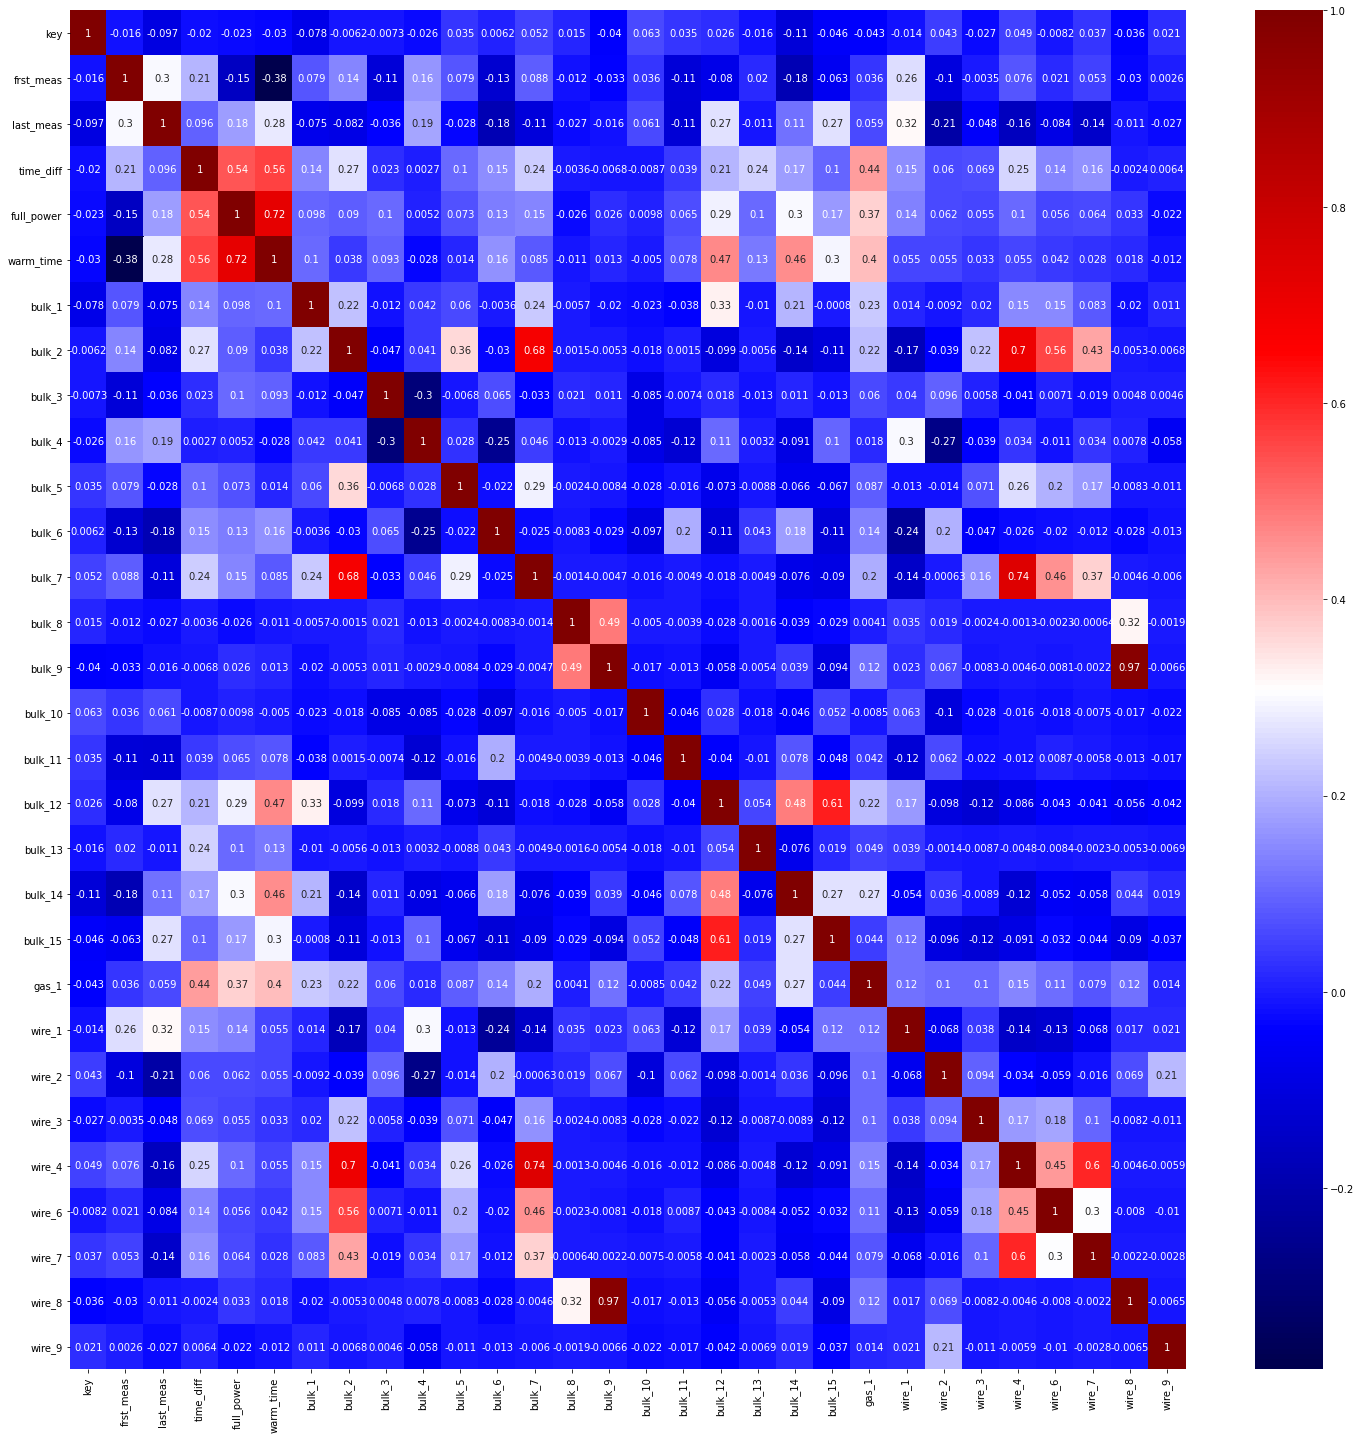

In [33]:
plt.figure(figsize=(25, 25))
sns.heatmap(data_full.corr(), annot = True, cmap='seismic');

In [34]:
data_full.corr()['last_meas'].sort_values(ascending=False)[1:]

wire_1        0.317575
frst_meas     0.301320
warm_time     0.278716
bulk_12       0.267424
bulk_15       0.266414
bulk_4        0.187970
full_power    0.175668
bulk_14       0.114617
time_diff     0.096447
bulk_10       0.061350
gas_1         0.059160
wire_8       -0.010767
bulk_13      -0.010920
bulk_9       -0.016075
bulk_8       -0.026587
wire_9       -0.027488
bulk_5       -0.028355
bulk_3       -0.035977
wire_3       -0.047537
bulk_1       -0.075206
bulk_2       -0.082454
wire_6       -0.084034
key          -0.097242
bulk_7       -0.107275
bulk_11      -0.114753
wire_7       -0.137262
wire_4       -0.159719
bulk_6       -0.181816
wire_2       -0.206672
Name: last_meas, dtype: float64

**Анализ результатов корреляции**  
По тепловому графику корреляции, а также по расчётной таблице, видно, что в прямом направлении корреляция `last_meas` (целевой признак) наиболее выражена с:
 - wire_1
 - frst_meas (первое измерение)
 - warm_time (продолжительность нагрева)
 - bulk_12
 - bulk_15  
 
но не превышает значений, при которых бы потребовалось их удаление перед использованием в обучении логистических моделей.  
Обратная корреляция наблюдается с:  
 - bulk_6
 - wire_2
 
но тоже незначительная.

Потребности в исключении каких-то признаков нет, можно переходить к разбиению датасета на выборки, обучению моделей и выбору гиперпараметров.

По остальным признакам наблюдается сильная корреляция между `full_power` & `warm_time`, что ожидаемо. Можно объединить указанные параметры в один, перемножив указанные, и назвать его `heat` (теплота).  
Из неожиданного: 
 * `bulk_2`-`bulk_7`,
 * `bulk_2`-`wire_4`,
 * `bulk_2`-`wire_6`,
 * `bulk_7`-`wire_4`,
 * `bulk_7`-`wire_4`,
 * `bulk_9`-`wire_8`,
 * `bulk_12`-`bulk_15`.
 
Для обучения линейной регресии один из признаков в каждой паре нужно будет дропнуть.

In [35]:
data_full['heat'] = data_full['full_power'] * data_full['warm_time']
data_full = data_full.drop(['full_power', 'warm_time'], axis=1)
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 29 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   key        2329 non-null   int64  
 1   frst_meas  2329 non-null   float64
 2   last_meas  2329 non-null   float64
 3   time_diff  2329 non-null   int64  
 4   bulk_1     2329 non-null   float64
 5   bulk_2     2329 non-null   float64
 6   bulk_3     2329 non-null   float64
 7   bulk_4     2329 non-null   float64
 8   bulk_5     2329 non-null   float64
 9   bulk_6     2329 non-null   float64
 10  bulk_7     2329 non-null   float64
 11  bulk_8     2329 non-null   float64
 12  bulk_9     2329 non-null   float64
 13  bulk_10    2329 non-null   float64
 14  bulk_11    2329 non-null   float64
 15  bulk_12    2329 non-null   float64
 16  bulk_13    2329 non-null   float64
 17  bulk_14    2329 non-null   float64
 18  bulk_15    2329 non-null   float64
 19  gas_1      2329 non-null   float64
 20  wire_1  

Теперь можно переходить к машинному обучению.

### Разбиение датафрема на пространство признаков. Формирование выборок

In [36]:
# key тоже можно удалить, он не нужен для обучения модели
features = data_full.drop(['last_meas', 'key'], axis=1)
target = data_full['last_meas']

In [37]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            random_state=RANDOM_STATE)

In [38]:
print(f'Доля тренировочной выборки: {round((features_train.shape[0] / data_full.shape[0]),2):0.2%}')

Доля тренировочной выборки: 75.00%


Можно сразу подготовить пространство признаков для простых моделей, типо линейной регрессии  и скалировать его.

In [39]:
features_train_lr = features_train.drop(['bulk_2', 'wire_4', 'wire_8', 'bulk_15'], axis=1)
scaler = StandardScaler()
scaler.fit(features_train)
features_train_lr_s = scaler.transform(features_train)

### Выводы  
1. Объединили обработанные датафреймы в единый датасет таким образом, чтобы сохранились признаки только по идентификатору партии, присуствующему во всех датафрееймах.  
2. Составили тепловую карту корреляции признаков, а также посчитали корреляцию целевого признака с остальными.  
3. Разделили датасет на пространство признаков и целевой признак.  
4. Выделили обучающую и тестовые выборки в пропорциях заказчика (3:1);
5. Для простых  моделей, например, линейной регрессии подготовили скалированное пространство признаков, с удалёнными коррелирующими признаками.

## Обучение моделей, сравнение результатов

In [40]:
# переменные, общие для всех моделей:
SCORING = 'neg_mean_absolute_error'
CV = 5

### Линейная регрессия

Функцию потерь выбираем из стандартной библиотеки: https://scikit-learn.org/stable/modules/model_evaluation.html

Пример применения библиотеки: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score

In [41]:
%%time

print('MAE для линейной регрессии без скалирования признаков')
lr_mae = cross_val_score(LinearRegression(), features_train_lr, target_train, cv=CV, scoring=SCORING).mean() * (-1)
print(f'MAE = {round(lr_mae,3)}')

MAE для линейной регрессии без скалирования признаков
MAE = 6.603
CPU times: user 200 ms, sys: 217 ms, total: 417 ms
Wall time: 385 ms


In [42]:
%%time

# попробуем с масштабированием признаков
print('MAE для линейной регрессии со скалированием признаков')
lr_s_mae = cross_val_score(LinearRegression(), features_train_lr_s, target_train, cv=CV, scoring=SCORING).mean() * (-1)
print(f'MAE = {round(lr_s_mae,3)}')

MAE для линейной регрессии со скалированием признаков
MAE = 6.585
CPU times: user 590 ms, sys: 920 ms, total: 1.51 s
Wall time: 1.58 s


Скалирование пространства признаков немного (~0.02) улучшает целевую метрику.

### Random Forest Regressor

Гиперпараметры подбираются релевантные, согласно описанию модели: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn-ensemble-randomforestregressor

Применение оптимизатора GridSearchCV построено на примере из документации: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

In [43]:
def rfr_objective(trial):
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 5, 11)
    
    
    rfr = RandomForestRegressor(criterion='mae',
                                max_features=max_features,
                                n_estimators=n_estimators,
                                max_depth=max_depth,
                                random_state=RANDOM_STATE)
    
    rfr_cv_mae = cross_val_score(rfr,
                                 features_train,
                                 target_train,
                                 scoring=SCORING,
                                 cv=CV).mean()*(-1)
    
    return rfr_cv_mae

In [44]:
%%time

print('Подбор гиперпараметров для модели RandomForestRegressor')
rfr_study = optuna.create_study(direction='minimize')
rfr_study.optimize(rfr_objective, n_trials=10) 

[I 2023-08-24 07:20:31,004] A new study created in memory with name: no-name-1a921112-f9d3-44ca-8125-5001c55c701b


Подбор гиперпараметров для модели RandomForestRegressor


[I 2023-08-24 07:21:38,749] Trial 0 finished with value: 6.783000819688904 and parameters: {'max_features': 'log2', 'n_estimators': 800, 'max_depth': 9}. Best is trial 0 with value: 6.783000819688904.
[I 2023-08-24 07:22:00,111] Trial 1 finished with value: 6.91507061809251 and parameters: {'max_features': 'log2', 'n_estimators': 300, 'max_depth': 6}. Best is trial 0 with value: 6.783000819688904.
[I 2023-08-24 07:22:17,286] Trial 2 finished with value: 6.8057803069995915 and parameters: {'max_features': 'sqrt', 'n_estimators': 200, 'max_depth': 7}. Best is trial 0 with value: 6.783000819688904.
[I 2023-08-24 07:25:56,375] Trial 3 finished with value: 6.55114651657798 and parameters: {'max_features': 'auto', 'n_estimators': 500, 'max_depth': 9}. Best is trial 3 with value: 6.55114651657798.
[I 2023-08-24 07:26:40,479] Trial 4 finished with value: 6.727826287351613 and parameters: {'max_features': 'sqrt', 'n_estimators': 400, 'max_depth': 9}. Best is trial 3 with value: 6.55114651657798

CPU times: user 14min 23s, sys: 1.45 s, total: 14min 24s
Wall time: 14min 27s


In [45]:
rfr_best_trial  = rfr_study.best_trial
rfr_mae_best = rfr_best_trial.value
print(f'Лучший покаазатель MAE для RFR: {round(rfr_mae_best,3)}')
rfr_best_params = rfr_best_trial.params
print(f'Лучшие гиперпараметры: {rfr_best_params}')

Лучший покаазатель MAE для RFR: 6.551
Лучшие гиперпараметры: {'max_features': 'auto', 'n_estimators': 500, 'max_depth': 9}


### CatBoost Regressor

Используем официальную документацию: https://catboost.ai/en/docs/concepts/python-reference_catboostregressor_get_all_params

Можно и статью на хабре: https://habr.com/ru/companies/otus/articles/527554/

In [46]:
%%time

print('MAE для CatBoost регрессии')
mae_cbr = (cross_val_score(CatBoostRegressor(loss_function='MAE', verbose=False, random_state=RANDOM_STATE), \
                                   features_train, target_train, cv=CV, scoring=SCORING).mean()*(-1))

# get_all_params() возвращает словарь со всеми параметрами модели
best_params_cbr = CatBoostRegressor(loss_function='MAE', verbose=False, random_state=RANDOM_STATE).fit(
    features_train, target_train).get_all_params()
print(f'Среднее значение MAE для CatBoostRegressor = {round(mae_cbr,3)}')
print('Лучшие гиперпарамтеры:')
display(best_params_cbr)

MAE для CatBoost регрессии
Среднее значение MAE для CatBoostRegressor = 6.347
Лучшие гиперпарамтеры:


{'nan_mode': 'Min',
 'eval_metric': 'MAE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Exact',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 140823,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'MAE',
 'learning_rate': 0.029999999329447743,
 'score_function': 'Cosine',
 'task_ty

CPU times: user 21.3 s, sys: 721 ms, total: 22 s
Wall time: 36.2 s


### LGBM Regressor

Хорошая статья на хабре по использованию модели: https://habr.com/ru/companies/skillfactory/articles/530594/

In [47]:
def lgbmr_objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, step=0.01)
    #n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    num_leaves = trial.suggest_int('num_leaves', 5, 16)
    
    lgbmr = LGBMRegressor(learning_rate=learning_rate,
                          #n_estimators=n_estimators,
                          num_leaves=num_leaves,
                          random_state=RANDOM_STATE)
    
    lgbmr_cv_mae = cross_val_score(lgbmr,
                                   features_train,
                                   target_train,
                                   scoring=SCORING,
                                   cv=CV).mean()*(-1)
    
    return lgbmr_cv_mae

In [48]:
%%time

print('Подбор гиперпараметров для модели LGBMRegressor')
lgbmr_study = optuna.create_study(direction='minimize')
lgbmr_study.optimize(lgbmr_objective, n_trials=10)

[I 2023-08-24 07:35:35,055] A new study created in memory with name: no-name-680f61a1-b123-4ae2-8263-ab222df68d02


Подбор гиперпараметров для модели LGBMRegressor


[I 2023-08-24 07:43:22,317] Trial 0 finished with value: 7.040987574955452 and parameters: {'learning_rate': 0.01, 'num_leaves': 16}. Best is trial 0 with value: 7.040987574955452.
[I 2023-08-24 07:50:17,539] Trial 1 finished with value: 6.458704602480698 and parameters: {'learning_rate': 0.09999999999999999, 'num_leaves': 6}. Best is trial 1 with value: 6.458704602480698.
[I 2023-08-24 08:00:09,323] Trial 2 finished with value: 6.422350326083636 and parameters: {'learning_rate': 0.09, 'num_leaves': 13}. Best is trial 2 with value: 6.422350326083636.
[I 2023-08-24 08:11:50,736] Trial 3 finished with value: 6.501757198424194 and parameters: {'learning_rate': 0.04, 'num_leaves': 10}. Best is trial 2 with value: 6.422350326083636.
[I 2023-08-24 08:25:17,211] Trial 4 finished with value: 7.079934710426666 and parameters: {'learning_rate': 0.01, 'num_leaves': 13}. Best is trial 2 with value: 6.422350326083636.
[I 2023-08-24 08:36:40,617] Trial 5 finished with value: 6.424084499808776 and pa

CPU times: user 1h 40min 47s, sys: 58.6 s, total: 1h 41min 45s
Wall time: 1h 42min 18s


In [49]:
lgbmr_best_trial  = lgbmr_study.best_trial
lgbmr_mae_best = lgbmr_best_trial.value
print(f'Лучший покаазатель MAE для LGBMR: {round(lgbmr_mae_best,3)}')
lgbmr_best_params = lgbmr_best_trial.params
print(f'Лучшие гиперпараметры: {lgbmr_best_params}')

Лучший покаазатель MAE для LGBMR: 6.396
Лучшие гиперпараметры: {'learning_rate': 0.06999999999999999, 'num_leaves': 15}


### XGB Regressor

Выбираем параметры согласно официальной документации: https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters

In [50]:
def xgbr_objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, step=0.01)
    #n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 11)
    
    
    xgbr = XGBRegressor(learning_rate=learning_rate,
                        #n_estimators=n_estimators,
                        max_depth=max_depth,
                        random_state=RANDOM_STATE)
    
    xgbr_cv_mae = cross_val_score(xgbr,
                                  features_train,
                                  target_train,
                                  scoring=SCORING,
                                  cv=CV).mean()*(-1)
    
    return xgbr_cv_mae

In [51]:
%%time

print('Подбор гиперпараметров для модели XGBRegressor')
xgbr_study = optuna.create_study(direction='minimize')
xgbr_study.optimize(xgbr_objective, n_trials=10)

[I 2023-08-24 09:17:54,147] A new study created in memory with name: no-name-2626eaac-15a5-46e6-86d7-dcba97b138df


Подбор гиперпараметров для модели XGBRegressor


[I 2023-08-24 09:20:32,413] Trial 0 finished with value: 27.184737717617942 and parameters: {'learning_rate': 0.04, 'max_depth': 8}. Best is trial 0 with value: 27.184737717617942.
[I 2023-08-24 09:21:55,638] Trial 1 finished with value: 75.94709298350037 and parameters: {'learning_rate': 0.03, 'max_depth': 6}. Best is trial 0 with value: 27.184737717617942.
[I 2023-08-24 09:23:18,038] Trial 2 finished with value: 75.94709298350037 and parameters: {'learning_rate': 0.03, 'max_depth': 7}. Best is trial 0 with value: 27.184737717617942.
[I 2023-08-24 09:36:20,622] Trial 3 finished with value: 6.675298599674133 and parameters: {'learning_rate': 0.09999999999999999, 'max_depth': 11}. Best is trial 3 with value: 6.675298599674133.
[I 2023-08-24 09:46:10,039] Trial 4 finished with value: 6.562180719026619 and parameters: {'learning_rate': 0.06999999999999999, 'max_depth': 11}. Best is trial 4 with value: 6.562180719026619.
[I 2023-08-24 09:52:00,328] Trial 5 finished with value: 6.3842704190

CPU times: user 45min 4s, sys: 17 s, total: 45min 21s
Wall time: 45min 44s


In [52]:
xgbr_best_trial  = xgbr_study.best_trial
xgbr_mae_best = xgbr_best_trial.value
print(f'Лучший покаазатель MAE для LGBMR: {round(xgbr_mae_best,3)}')
xgbr_best_params = xgbr_best_trial.params
print(f'Лучшие гиперпараметры: {xgbr_best_params}')

Лучший покаазатель MAE для LGBMR: 6.35
Лучшие гиперпараметры: {'learning_rate': 0.09, 'max_depth': 5}


### SVM Regressor (SVR)

Для подбора гиперпарамтеров используем офиц. докум.: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR

In [53]:
def svr_objective(trial): 
    reg_params = {
        #'kernel' : trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'kernel' : trial.suggest_categorical('kernel', ['rbf']),
        'C' : trial.suggest_loguniform('C', 0.3, 10.0),
        'gamma' : trial.suggest_loguniform('gamma', 0.001, 0.01),
        'epsilon' : trial.suggest_float('epsilon', 0.05, 0.5)
    }    
    
    svr = SVR(**reg_params)
    
    svr_cv_mae = cross_val_score(svr,
                                 features_train,
                                 target_train,
                                 scoring=SCORING,
                                 cv=CV).mean()*(-1)
    
    return svr_cv_mae

In [54]:
%%time

print('Подбор гиперпараметров для модели SVR')
svr_study = optuna.create_study(direction='minimize')
svr_study.optimize(svr_objective, n_trials=1000)

[I 2023-08-24 10:03:38,331] A new study created in memory with name: no-name-05c1e56a-55d0-4af7-9930-21b24ce024e3


Подбор гиперпараметров для модели SVR


[I 2023-08-24 10:03:39,126] Trial 0 finished with value: 8.041683166666644 and parameters: {'kernel': 'rbf', 'C': 1.59462716539469, 'gamma': 0.0076511859601254015, 'epsilon': 0.12916911732135522}. Best is trial 0 with value: 8.041683166666644.
[I 2023-08-24 10:03:39,936] Trial 1 finished with value: 8.04145015480721 and parameters: {'kernel': 'rbf', 'C': 7.908524541164831, 'gamma': 0.00451199598162715, 'epsilon': 0.45335824282950815}. Best is trial 1 with value: 8.04145015480721.
[I 2023-08-24 10:03:40,755] Trial 2 finished with value: 8.041423601871685 and parameters: {'kernel': 'rbf', 'C': 7.940644290164591, 'gamma': 0.00885837380758668, 'epsilon': 0.17314489881547462}. Best is trial 2 with value: 8.041423601871685.
[I 2023-08-24 10:03:41,602] Trial 3 finished with value: 8.041446917453746 and parameters: {'kernel': 'rbf', 'C': 7.947019845696923, 'gamma': 0.0015427726514220916, 'epsilon': 0.39063802860386027}. Best is trial 2 with value: 8.041423601871685.
[I 2023-08-24 10:03:42,372]

CPU times: user 13min 13s, sys: 1.4 s, total: 13min 14s
Wall time: 13min 19s


In [55]:
svr_best_trial  = svr_study.best_trial
svr_mae_best = svr_best_trial.value
print(f'Лучший покаазатель MAE для LGBMR: {round(svr_mae_best,3)}')
svr_best_params = svr_best_trial.params
print(f'Лучшие гиперпараметры: {svr_best_params}')

Лучший покаазатель MAE для LGBMR: 8.041
Лучшие гиперпараметры: {'kernel': 'rbf', 'C': 0.30019556277306747, 'gamma': 0.0010967990903226548, 'epsilon': 0.41972319442171896}


### Сводная таблица результатов

In [63]:
columns = ['LinearRegression (скал.дан.)', 'RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor', 'XGBRegressor', 'SVR']
data = {'MAE на CV':[lr_s_mae, rfr_mae_best, mae_cbr, lgbmr_mae_best, xgbr_mae_best, svr_mae_best],
        'Время выполнения':['1.58 s', '14min 27s', '36.2 s', '1h 40min 47s', '45min 44s', '13min 13s']}

pivot_table_results = pd.DataFrame(data=data, index=columns)
display(pivot_table_results)

,MAE на CV,Время выполнения
LinearRegression (скал.дан.),6.584876,1.58 s
RandomForestRegressor,6.551147,14min 27s
CatBoostRegressor,6.347122,36.2 s
LGBMRegressor,6.395878,1h 40min 47s
XGBRegressor,6.349713,45min 44s
SVR,8.040555,13min 13s


### Выводы  
Первое, что хотелось бы отметить, что оптимизация в библиотеке Optuna осуществляется алгоритмом Байесовской оптимизации.  
В принципе, по результатам кросс-валидации с подбором гиперпараметрам , все перечисленные модели, кроме SVR, прошли по показателю целевой метрики (MAE < 6.8), однако не имеет смысла выполнять проверку на тестовой выборке для всех моделей, так как заказчику нужно будет предложить одну конкретную. Поэтому необходимо выбрать лучшую на основании совокупности показателей, таких как величина целевой метрики и время проведения кросс-валидации.  
Самый плохой результат принадлежит модели SVR. Не смотря на увеличенное количество "прогонов" (trail) до 1000 итераций, добиться результата MAE лучше 8.041 не удалось. Отбрасываем данную модель.  
Опишем остальные результаты:
* Самый быстрый (901 ms) результат принадлежит `LinearRegression` на скалированных данных, но из прошедших по целевой метрике моделей, линейная регрессия продемонстрировала самый плохой результат - MAE = 6.585, исключаем её из дальнейшего рассмотрения.  
* `Random Forest Regressor` демонстрирует результат чуть лучше, чем у линейной регрессии (MAE = 6.551), обучение модели с учётом перебора гиперпараметров на кросс-валидации заняло всего 14min 27s. Данную модель исключаем, так как у тройки лидеров целевая метрика находится на уровне ниже 6.4.
* `CatBoostRegressor` демострирует хорошие показатель целевой метрики (6.347) при времени на подбор параметров 36.2 секунды, хороший результат.
* `LGBMRegressor` показал достаточно высокое значение MAE = 6.396. Но время на подбор гиперпарамтеров составило 1h 40min 47s, это самый плохой результат.
* Для `XGBRegressor` время обучения с подбором гиперпарметров на кроссвалидации составило поменьше 45min 44s, при показателе MAE = 6.349.

По результатам сравнения результатов целевого показателя и затраченного времени, лучшей моделью считаем CatBoost Regressor, её MAE на обучающей выборке с кросс-валидацией составляет 6.347, время на кросс-валидации 36.2 секунды. Проверку на тестовой выборке будем проходить именно для этой модели с её лучшими параметрами.

##  Проверка целевой метрики на выбранной модели с тестовой выборкой

### Проверка целевого покаазателя на выбранной модели

In [64]:
%%time

# создаём финальную модель на основании лучшей
model_final = CatBoostRegressor(loss_function='MAE', verbose=False)
# укзываем ей гиперпараметры, полученные на предыдущем шаге
model_final.set_params(**best_params_cbr)
# обучаем
model_final.fit(features_train, target_train)
# собираем предсказание
target_predict = model_final.predict(features_test)
# сравниваем предсказание с целевым признаком в тестовой выборке
test_mae_cbr = mean_absolute_error(target_predict, target_test)
print(f'MAE для финальной модели на базе CatBoostRegressor = {round(test_mae_cbr,3)}')

MAE для финальной модели на базе CatBoostRegressor = 6.27
CPU times: user 3.12 s, sys: 71 ms, total: 3.19 s
Wall time: 4.8 s


In [65]:
for strategy in ['mean', 'median']:
    dummy = DummyRegressor(strategy=strategy)
    dummy.fit(features_train, target_train)   
    dummy_predict = dummy.predict(features_test)   
    dummy_mae = mean_absolute_error(target_test, dummy_predict)   
    print('Для стратегии', strategy, f'MAE = {round(dummy_mae,3)}')

Для стратегии mean MAE = 8.127
Для стратегии median MAE = 8.101


### Анализ результата.

Целевой показатель выбранной модели на тестовых данных **укладывается** в требуемый диапазон (MAE < 6.8).  
Метрики константной модели, что для среднего, что для медианного значения оказались хуже, чем у `CatBoostRegressor`, таким образом, разработанная нами модель **прошла тест на адекватность**.

### Оценка значимости признаков

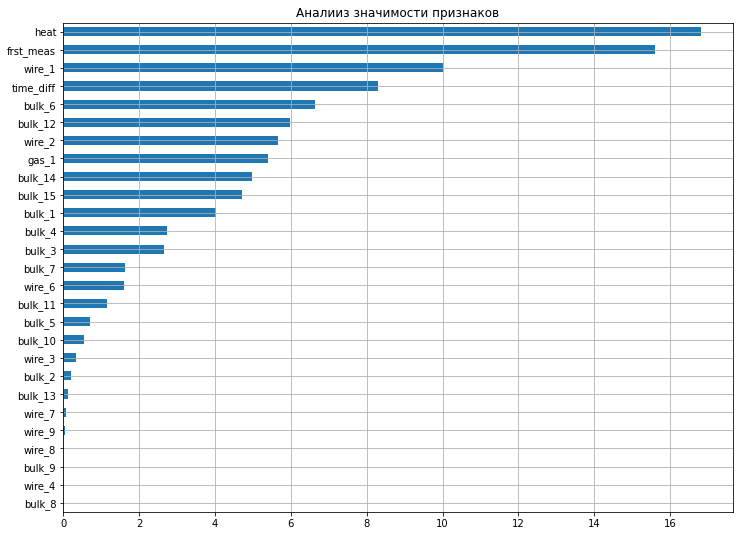

In [66]:
pd.DataFrame(data={'score': model_final.feature_importances_}, 
             index=features_train.columns).sort_values(by='score').plot(kind='barh',
                                                                        grid=True,
                                                                        figsize=(12,9),
                                                                        legend=False)
plt.title('Аналииз значимости признаков');

На сколько мы видим по графику, наиболее важными признаками являются:
 - heat - тепло, затрачиваеемое на нагрев (ожидаемо);
 - frst_meas - начальная температура;
 - wire_1 - подача проволоки;
 - time_diff - разница между первым и последним измерением в секундах.
 
Бесполезными оказались:
 - wire_4;
 - wire_8;
 - bulk_9;
 - bulk_8.

## Общий вывод и отчёт о проделанной работе

1. **Наибольшую часть временных затрат и сложность составила предобработка данных (exploratory data analysis, EDA)**, так как они были предоставлены в разных датафреймах (таблицах), обладали выбросами (статистически неуместными значениями, аномалиями), пропусками и созависимыми признаками (факторами). Это было исправлено. В частности:
 - из данных о замере температуры были удалены сведения о промежуточных замерах, а также отброшены данные с единственным замером, вместо фактически указанного времени оставили разницу в секундах между первым и последним замером;
 - данные с пропусками были удалены;
 - данные о нагреве сплава были сгруппированы относительно `key`, так как нам нужны были только общие данные, а не за конкретную итерацию, время также преобразовали в интервал;
 - вместо активной и реактивной мощности был введён новый признак - полная мощность, представляющая из себя корень из суммы квадратов указанных мощностей. Полную мощность в последствии заменили новым признаком "heat" (тепло) по формуле: полная мощность * продолжительность нагрева = тепло;
 - пропуски в датафреймах (таблицах) о добавляемой проволоке или сыпучих материалах были заполнены 0;
 - разного рода аномалии, будь то слишком маленькие или слишком большие значения, были удалены.  
2. На основании оригинальных данных был сформирован **подготовленный датасет**, представляющий из себя обобщаю таблицу, объединённую по уникальному ключу `key`, что позволило сохранить записи из всех датафреймов, относящиеся только к существующим номерам партий.  
3. Обобщённый датасет (таблицу) проверили на **мультиколлинеарность**, то есть оказание взаимного влияния между факторами, построена тепловая карта для наглядности, удалили признаки, оказовавшие сильное совместное влияние (пункт 3.2).
4. Из полученного объединённого датасета были сформированы обучающая и тестовая выборки для машинного обучения в пропорциях **3:1**, разделённые позже на пространство признаков и целевой признак - конечная **температура нагрева сплава**.  
5. Проведено исседование группы моделей с подбором гипер-параметров и кросс-валидацией на предмет самого лучшего (наименьшего) показателя MAE (*mean absolute error*). Подбор гиперпараметров осуществлялся библиотекой Optuna, исследовались линейная регрессия, Random Forest Regressor, CatBoost Regressor, LGBM Regressor, XGB Regressor, SVM Regressor. Обязательным условием являлось **MAE < 6.8**, то есть средняя ошибка предсказания модели составила бы менее 6.8 градусов. Результаты сведены в общую таблицу и представлены в пункте 4.7 данного отчёта. Лучший показатель по целевой метрике и скорости показала модель с  **CatBoost Regressor: MAE = 6.347**  
6. **Лучшие гиперпараметры** модели CatBoost Regressor:  

{'nan_mode': 'Min', 'eval_metric': 'MAE', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Exact', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': True, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False,
 'random_seed': 140823, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MAE', 'learning_rate': 0.029999999329447743, 'score_function': 'Cosine', 'task_type': 'CPU', 'leaf_estimation_iterations': 1, 'bootstrap_type': 'MVS', 'max_leaves': 64}  
 
7. При проверке модели на **тестовой** выборке показатель целевой метрики составил **MAE = 6.27**, это полностью удовлетворяет требованиям заказчика. Финальная  модель **успешно** прошла проверку на адекватность. **Можно рекомендовать** её внедрение в производство в целях предсказания конечной температуры сплава.   
8. **Провели проверку факторов по важности**, построили наглядный график (пункт 5.3). Наиболее важными признаками оказались:
 * heat - тепло, затрачиваеемое на нагрев сплава;
 * frst_meas - начальная температура сплава;
 * wire_1 - подача проволоки в сплав;
 * time_diff - разница между первым и последним измерением сплава в секундах.  
9. **Основные сложности** в обработке данных были связаны с неполным пониманием технологического процесса, в частности, причины большого количества пропусков в таблицах, посвящённых подаче сыпучих материалов и проволоки в сплав. По этой же причине было было потрачено некоторое время на принятие решения по методу обработки данных в таблице `data_arc_new`, содержащей информацию по отдельным итерациям нагрева сплава. Определение подбираемых для моделей релевантных гиперпараметров также представляло некоторые затруднения.  **Решением** возникших трудностей стала информация из вебинара с тимлидом, обращение к описанию технологического процесса в открытых источниках, изучение опыта других исследователей, а также активное обсуждение проекта с коллегами в чатах.
10. В целом, **исследование в рамках проекта прошло согласно заявленному в начале плану, все пункты удалось выполнить, получена рабочая модель, удовлетворяющая требованиям заказчика по целевой метрике**. 